# 03. PyTroch Autograd Tutorial

**Goals**: to understand what a computation graph is, the backward pass, and gradients, and how to use them in PyTorch.

**Source**: [PyTorch Docs Autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

This notebook will provide examples and explanations of basics of automatic differentiation in PyTorch using the torch.autograd module

## 1. Imports and basic configuration

In [70]:
import torch
import numpy as np

# Basic checking
print(f"PyTroch vesrion: {torch.__version__}")
print(f"CUDA is available: {torch.cuda.is_available()}")

# Establish a seed value to ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)

PyTroch vesrion: 2.9.0+cpu
CUDA is available: False


## 2. Basic concepts: Tensors and requires_grad

### 2.1. Creating tensors with requires_grad=True

In [71]:
# Method 1: requires_grad when creating
x = torch.tensor([1., 2., 3.], requires_grad=True)
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=False)

tensors = {'x': x, 'w': w, 'b': b}
for name, tensor in tensors.items():
    print(f"Tensor {name}")
    print(f"    value: {tensor}")
    print(f"    requires_grad: {tensor.requires_grad}")
    print(f"    grad: {tensor.grad}")
    print(f"    dtype: {tensor.dtype}\n")

Tensor x
    value: tensor([1., 2., 3.], requires_grad=True)
    requires_grad: True
    grad: None
    dtype: torch.float32

Tensor w
    value: tensor([[ 0.3367,  0.1288,  0.2345],
        [ 0.2303, -1.1229, -0.1863],
        [ 2.2082, -0.6380,  0.4617],
        [ 0.2674,  0.5349,  0.8094],
        [ 1.1103, -1.6898, -0.9890]], requires_grad=True)
    requires_grad: True
    grad: None
    dtype: torch.float32

Tensor b
    value: tensor([0.9580, 1.3221, 0.8172])
    requires_grad: False
    grad: None
    dtype: torch.float32



**Note**: by default, tensors are created with the parameter *requires_grad=False*.

### 2.2. Changing requires_grad for existing tensors

In [72]:
# Method 2: using .requires_grad_()
x = torch.tensor([1., 2., 3.], requires_grad=False)
print(f"Before: x.requires_grad = {x.requires_grad}")

x.requires_grad_(True)
print(f"After: x.requires_grad = {x.requires_grad}")

# Method 3: turn off tracking
x.requires_grad_(False)
print(f"Turned off: x.requires_grad = {x.requires_grad}")

Before: x.requires_grad = False
After: x.requires_grad = True
Turned off: x.requires_grad = False


## 3. Computational Graph

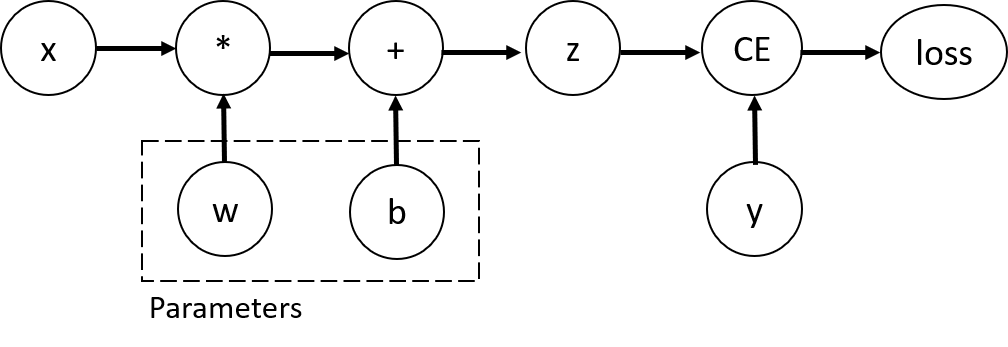

### 3.1. Plotting a graph

In [73]:
# Simple single-layer neural network
x = torch.ones(5) # input data
y = torch.zeros(3) # output data

w = torch.randn(5, 3, requires_grad=True) 
b = torch.randn(3, requires_grad=True)

z = torch.matmul(x, w) + b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

print("Leaves nodes (parameters of the model):")
print(f"  w.is_leaf: {w.is_leaf}, requires_grad: {w.requires_grad}")
print(f"  b.is_leaf: {b.is_leaf}, requires_grad: {b.requires_grad}")

print("\nPlotting computing graph:")

print(f"  After z = matmul(x,w) + b:")
print(f"    z.grad_fn = {z.grad_fn}")
print(f"    z.is_leaf = {z.is_leaf}")

print(f"  After loss = BCE(z, y):")
print(f"    loss.grad_fn = {loss.grad_fn}")
print(f"    loss.is_leaf = {loss.is_leaf}")

Leaves nodes (parameters of the model):
  w.is_leaf: True, requires_grad: True
  b.is_leaf: True, requires_grad: True

Plotting computing graph:
  After z = matmul(x,w) + b:
    z.grad_fn = <AddBackward0 object at 0x71da3dc6fa00>
    z.is_leaf = False
  After loss = BCE(z, y):
    loss.grad_fn = <BinaryCrossEntropyWithLogitsBackward0 object at 0x71da3dc6fa00>
    loss.is_leaf = False


**Graph**: *w, b, x, y* (leaves) $\to$ *z* $\to$  *loss* (root)

### 3.2. Structure of the graph

In [ ]:
def print_graph_structure(tensor, indent=0):
    prefix = " " * indent
    if tensor.is_leaf:
        print(f"{prefix} Leaf: {tensor.shape}")
    else:
        print(f"{prefix}{tensor.grad_fn.__class__.__name__}: {tensor.shape}")
        if hasattr(tensor.grad_fn, "next_functions"):
            for next_fn, _ in tensor.grad_fn.next_functions:
                if next_fn is not None:
                    if hasattr(next_fn, 'variable'):
                        print_graph_structure(next_fn.variable, indent + 1)
                    else:
                        print(f"{prefix} └─ {next_fn.__class__.__name__}")


print("Structure of computing graph:")
print("\nRoot (loss):") # ...<BinaryCrossEntropyWithLogitsBackward0 object at 0x71da3dbbb190>
print_graph_structure(loss)

## 4. Computing Gradients: Forward and Backward Passes

### 4.1. Forward Pass

In [ ]:
print("Example: y = (x * w + b) ^ 2 \n")
x = torch.tensor(2.0, requires_grad=False)
w = torch.tensor(3.0, requires_gzrad=True)
b = torch.tensor(1.0, requires_grad=True)

print("Input data:")
print(f"  x = {x.item():.1f}")
print(f"  w = {w.item():.1f}")
print(f"  b = {b.item():.1f}")

print("\nForward pass:")
z = x * w + b  # z = 2 * 3 + 1 = 7
print(f"  z = x * w + b = {x.item()} * {w.item()} + {b.item()} = {z.item()}")

y = z ** 2  # y = 7 ^ 2 = 49
print(f"  y = z ^ 2 = {z.item()} ^ 2 = {y.item()}")

print(f"\nComputing graph:")
print(f"  y.grad_fn = {y.grad_fn}")
print(f"  z.grad_fn = {z.grad_fn}")

### 4.2. Backward Pass

In [91]:
# Computing gradients
print("Backward pass:\n")

# y = (x * w + b) ^ 2
# dy/dw = 2 * (x * w + b) * x = 2 * z * x 
# dy/db = 2 * (x * w + b) * 1 = 2 * z

manual_dydy = 1.0  # dy/dy = 1
manual_dzdy = 2 * z.item()  # dz/dy = 2 * z (из y = z ^ 2)
manual_dydw = manual_dzdy * x.item()  # dy/dw = (dy/dz) * (dz/dw)
manual_dydb = manual_dzdy * 1.0  # dy/db = (dy/dz) * (dz/db)

print(f"Manual calculations:")
print(f"  dy/dz = 2 * z = 2 * {z.item()} = {manual_dzdy}")
print(f"  dy/dw = dy/dz * dz/dw = {manual_dzdy} * {x.item()} = {manual_dydw}")
print(f"  dy/db = dy/dz * dz/db = {manual_dzdy} * 1 = {manual_dydb}")

print(f"\nAfter y.backward():")
y.backward()

print(f"  w.grad = {w.grad}")
print(f"  b.grad = {b.grad}")

Backward pass:

Manual calculations:
  dy/dz = 2 * z = 2 * 7.0 = 14.0
  dy/dw = dy/dz * dz/dw = 14.0 * 2.0 = 28.0
  dy/db = dy/dz * dz/db = 14.0 * 1 = 14.0

After y.backward():
  w.grad = 28.0
  b.grad = 14.0


## 5. Practical example: Simple linear model

### 5.1. Creating a model and generating data

In [93]:
# Model: y_pred = x * w + b
# Goal: good predictions based on our data

# Generating data
n_samples = 100
n_features = 10

X = torch.randn(n_samples, n_features)
w_true = torch.randn(n_features, 1)
y_true = X @ w_true + torch.randn(n_samples, 1) * 0.1 # adding noise


print(f"Training data:")
print(f"  X.shape = {X.shape}")
print(f"  y_true.shape = {y_true.shape}")
print(f"  y_true: mean={y_true.mean():.4f}, std={y_true.std():.4f}")

Training data:
  X.shape = torch.Size([100, 10])
  y_true.shape = torch.Size([100, 1])
  y_true: mean=-0.244, std=2.714


### 5.2. Initialization of parameters

In [104]:
# Parameters of model (SHOULD BE leave nodes with requires_grad=True)
w = torch.randn(n_features, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

print(f"Initializated parameters:")
print(f"  w.shape = {w.shape}, requires_grad = {w.requires_grad}")
print(f"  b.shape = {b.shape}, requires_grad = {b.requires_grad}")
print(f"  w.is_leaf = {w.is_leaf}")
print(f"  b.is_leaf = {b.is_leaf}")

Initializated parameters:
  w.shape = torch.Size([10, 1]), requires_grad = True
  b.shape = torch.Size([1]), requires_grad = True
  w.is_leaf = True
  b.is_leaf = True


### 5.3. Forward pass and computing loss

In [105]:
def forward(X, w, b):
    """Computing y_pred = X * w + b"""
    return X @ w + b

def compute_loss(y_pred, y_true):
    """Computing MSE loss: (1/n) * sum((y_pred - y_true) ^ 2)"""
    return torch.mean((y_pred - y_true) ** 2)
    
print(f"Forward pass:")
y_pred = forward(X, w, b)

print(f"  y_pred.shape = {y_pred.shape}")
print(f"  y_pred: mean = {y_pred.mean():.4f}, std = {y_pred.std():.4f}")
print(f"  y_pred.requires_grad = {y_pred.requires_grad}")
print(f"  y_pred.grad_fn = {y_pred.grad_fn}")

print(f"\nLoss computing:")
loss = compute_loss(y_pred, y_true)

print(f"  loss = {loss.item():.4f}")
print(f"  loss.requires_grad = {loss.requires_grad}")
print(f"  loss.grad_fn = {loss.grad_fn}")

Forward pass:
  y_pred.shape = torch.Size([100, 1])
  y_pred: mean = -0.263, std = 2.905
  y_pred.requires_grad = True
  y_pred.grad_fn = <AddBackward0 object at 0x71daac621a50>

Loss computing:
  loss = 7.2981
  loss.requires_grad = True
  loss.grad_fn = <MeanBackward0 object at 0x71da3dc59480>


### 5.4. Backward Pass and optimization

In [106]:
print("Gradients computing (loss.backward()):")
loss.backward()

print(f"  w.grad.shape = {w.grad.shape}")
print(f"  b.grad.shape = {b.grad.shape}")
print(f"  ||w.grad|| = {torch.norm(w.grad):.4f}")
print(f"  ||b.grad|| = {torch.norm(b.grad):.4f}")
print(f"\nFirst 5 elements w.grad: {w.grad[:5].squeeze()}")

Gradients computing (loss.backward()):
  w.grad.shape = torch.Size([10, 1])
  b.grad.shape = torch.Size([1])
  ∥w.grad∥ = 5.1853
  ∥b.grad∥ = 0.0374

First 5 elements w.grad: tensor([ 0.6189, -1.4967,  0.4962,  0.4911,  3.0871])


### 5.5. Updating parameters (manual gradient descent)

In [109]:
# PAY ATTENTION: There is NO need to track the graph when updating the parameters!
# using torch.no_grad() or .detach()

learning_rate = 0.01
print(f"Updating parameters with learning_rate = {learning_rate}\n")

with torch.no_grad():  # Important!
    w -= learning_rate * w.grad
    b -= learning_rate * b.grad

print(f"Parameters are updated")
print(f"  w[0] new = {w[0].item():.4f}")
print(f"  b new = {b.item():.4f}")

Updating parameters with learning_rate = 0.01

Parameters are updated
  w[0] new = 1.4621
  b new = 0.0007


## 6. Important features of Autograd

### 6.1. Gradient accumulation demonstration

In [115]:
x = torch.tensor(2.0, requires_grad=True)
y = x ** 2

# First backward
y.backward(retain_graph=True)
print(f"\nAfter first y.backward():")
print(f"  x.grad = {x.grad} (expect: dy/dx = 2x = 4)")

# Second backward 
y.backward(retain_graph=True)
print(f"\nAfter second y.backward() БЕЗ очистки:")
print(f"  x.grad = {x.grad} (Gradients have accumulated!)")

# Clearning gradients
x.grad.zero_()
print(f"\nAfter x.grad.zero_():")
print(f"  x.grad = {x.grad}")

# Third backward after cleaning
y.backward()
print(f"\nAfter third y.backward():")
print(f"  x.grad = {x.grad} (As expected!)")

Demonstration of accumulation of gradients:

After first y.backward():
  x.grad = 4.0 (expect: dy/dx = 2x = 4)

After second y.backward() БЕЗ очистки:
  x.grad = 8.0 (Gradients have accumulated!)

After x.grad.zero_():
  x.grad = 0.0

After third y.backward():
  x.grad = 4.0 (As expected!)


### 6.2. Deactivating tracking: torch.no_grad() and .detach()

In [137]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

print("\nMethod 1: context manager torch.no_grad()")
with torch.no_grad():
    y = x ** 1
    print(f"  Inside no_grad(): x.requires_grad = {x.requires_grad}")
    print(f"  Inside no_grad(): y.requires_grad = {y.requires_grad}")
print(f"\n  Outside no_grad(): x.requires_grad = {x.requires_grad}")
print(f"  Outside no_grad(): y.requires_grad = {y.requires_grad}")
print(f"\n  Are y and x different objects? {y is not x}")
print(f"  Is data separated? {y.data_ptr() == x.data_ptr()}")

print("\nMethod 2: detach()")
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = x.detach()  # New tensor without tracking
print(f"  x.requires_grad = {x.requires_grad}")
print(f"  y.requires_grad = {y.requires_grad}")
print(f"  Are y and x different objects? {y is not x}")
print(f"  Is data separated? {y.data_ptr() == x.data_ptr()}")


Method 1: context manager torch.no_grad()
  Inside no_grad(): x.requires_grad = True
  Inside no_grad(): y.requires_grad = False

  Outside no_grad(): x.requires_grad = True
  Outside no_grad(): y.requires_grad = False

  Are y and x different objects? True
  Is data separated? False

Method 2: detach()
  x.requires_grad = True
  y.requires_grad = False
  Are y and x different objects? True
  Is data separated? True


### 6.3. Only leaf nodes receive gradients

In [141]:
w = torch.randn(2, requires_grad=True)  # Leaf node
x = torch.randn(2)

z = x @ w  # An intermediate node (NOT a leaf node)
y = z ** 2  # Root node

print(f"w.is_leaf = {w.is_leaf}, requires_grad = {w.requires_grad}")
print(f"z.is_leaf = {z.is_leaf}, requires_grad = {z.requires_grad}")
print(f"y.is_leaf = {y.is_leaf}, requires_grad = {y.requires_grad}")

y.backward()

print(f"\nAfter backward():")
print(f"  w.grad = {w.grad}  there is a gradient (leaf node)")
print(f"  z.grad = {z.grad}  there is no gradient (intermediate node)")
print(f"  y.grad = {y.grad}  there is no gradient (root node)")

w.is_leaf = True, requires_grad = True
z.is_leaf = False, requires_grad = True
y.is_leaf = False, requires_grad = True

After backward():
  w.grad = tensor([0.9077, 1.7289])  there is a gradient (leaf node)
  z.grad = None  there is no gradient (intermediate node)
  y.grad = None  there is no gradient (root node)


/tmp/ipykernel_1507/1218735813.py:15: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more information. (Triggered internally at /pytorch/build/aten/src/ATen/core/TensorBody.h:489.)
  print(f"  z.grad = {z.grad}  there is no gradient (intermediate node)")
/tmp/ipykernel_1507/1218735813.py:16: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access t

### 6.4. Jacobian product

In [146]:
# Vector function: f(x) = [x_1^2, 2 * x_2, x_3]
x = torch.tensor([1., 2., 3.], requires_grad=True)
y = torch.cat([x[0:1] ** 2, 2 * x[1:2], x[2:3]])

print(f"x = {x}")
print(f"y = [x_1^2, 2x_2, x_3] = {y}")
print(f"y.shape = {y.shape}")

# For a non-scalar output, we pass the vector to the backward
print(f"\nWe're calling y.backward(torch.ones_like(y)):")
v = torch.ones_like(y)  # Vector for the Jacobian product
print(f"  v = {v}")

y.backward(v) # Inside, the Jacobian is considered

print(f"\nResult x.grad = {x.grad}")
print(f"  This is v^T * J, где J — the Jacobian matrix")

x = tensor([1., 2., 3.], requires_grad=True)
y = [x_1^2, 2x_2, x_3] = tensor([1., 4., 3.], grad_fn=<CatBackward0>)
y.shape = torch.Size([3])

We're calling y.backward(torch.ones_like(y)):
  v = tensor([1., 1., 1.])

Result x.grad = tensor([2., 2., 1.])
  This is v^T * J, где J — the Jacobian matrix


## 7. Full training cycle

In [151]:
# Data
torch.manual_seed(42)
X_train = torch.randn(50, 3)
w_true = torch.tensor([1.0, -0.5, 0.3])
y_train = X_train @ w_true + torch.randn(50) * 0.1

# Parameters
w = torch.randn(3, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# Hyperparameters
learning_rate = 0.1
n_epochs = 30

print(f"learning_rate = {learning_rate}")
print(f"True weights = {w_true}\n")

losses = []
for epoch in range(n_epochs):
    # Forward pass
    y_pred = X_train @ w + b
    loss = torch.mean((y_pred - y_train) ** 2)
    losses.append(loss.item())
    
    # Backward pass
    if w.grad is not None:
        w.grad.zero_()  # Old gradients clearning
    if b.grad is not None:
        b.grad.zero_()
    
    loss.backward()
    
    # Updating parameters
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad
    
    print(f"Epoch {epoch+1:2d}: loss = {loss.item():.4f}, w = {w.detach().numpy()}")

print(f"\nFinal weights (trained):\n  {w.detach().numpy()}")
print(f"True weights:\n  {w_true.numpy()}")

learning_rate = 0.1
True weights = tensor([ 1.0000, -0.5000,  0.3000])

Epoch  1: loss = 1.0321, w = [ 0.49692243 -0.25321358  1.1287315 ]
Epoch  2: loss = 0.7468, w = [ 0.58220905 -0.28660828  1.0113174 ]
Epoch  3: loss = 0.5417, w = [ 0.6525215 -0.315515   0.9103589]
Epoch  4: loss = 0.3940, w = [ 0.710656   -0.34045961  0.82364005]
Epoch  5: loss = 0.2874, w = [ 0.7588513  -0.36193043  0.74921954]
Epoch  6: loss = 0.2104, w = [ 0.7989068  -0.38037243  0.68540335]
Epoch  7: loss = 0.1547, w = [ 0.83227456 -0.39618546  0.6307178 ]
Epoch  8: loss = 0.1144, w = [ 0.8601306  -0.40972486  0.5838845 ]
Epoch  9: loss = 0.0852, w = [ 0.88343114 -0.4213039   0.5437967 ]
Epoch 10: loss = 0.0641, w = [ 0.90295625 -0.43119684  0.5094986 ]
Epoch 11: loss = 0.0487, w = [ 0.91934466 -0.4396425   0.48016566]
Epoch 12: loss = 0.0376, w = [ 0.9331209  -0.44684795  0.4550879 ]
Epoch 13: loss = 0.0295, w = [ 0.94471717 -0.4529921   0.43365467]
Epoch 14: loss = 0.0236, w = [ 0.9544905  -0.45822912  0.415

# 8. Conclusion and notes

### We learned:
1. **A computational graph** — is a DAG where the leaves are the parameters and the root is the loss.
2. **requires_grad=True** — must be set for the model parameters
3. **Forward pass** — calculating y_pred and loss, plotting
4. **Backward pass** — calculation of gradients
5. **Gradients are calculated automatically** — no need to write formulas manually
6. **Only leaf nodes receive gradients** — there are no intermediate nodes
7. **Gradients accumulate ** — you need to call .zero_() before the new backward
8. **torch.no_grad()** — use it to disable tracking when updating parameters.

### Practical notes:

``` python
# 1. Initialization
w = torch.randn(n, requires_grad=True)  # Model Parameters
x = torch.randn(n)                      # Data (equal to requires_grad=False)

# 2. Forward pass
y_pred = model(x, w)
loss = loss_fn(y_pred, y_true)

# 3. Backward pass
w.grad.zero_()  # Old gradients clearning
loss.backward()  # New gradients computing

# 4. Updating parameters
with torch.no_grad():
    w -= learning_rate * w.grad
```